In [1]:
"""
Pressure release duct
"""

import numpy as np
from math import pi
import matplotlib.pyplot as plt
from scipy.special import hankel1

fc = 20.  # frequency (Hz)
c = 1500.  # sound speed (m/s)
D = 100.  # duct depth (m)

zsrc = 36.  # source depth (m)
zrcr = 6.  # receiver depth (m)

max_range = 3e3
numr = 300
numkr = 1000
raxis = (np.arange(numr) + 1) * max_range / numr

kc = 2 * pi * fc / c

In [2]:
# image source solution
maxis = np.arange(500)
p_img = 0
for m in maxis:
    rm1 = np.sqrt(raxis ** 2 + (2 * D * m - zsrc + zrcr) ** 2)
    rm2 = np.sqrt(raxis ** 2 + (2 * D * (m + 1) - zsrc - zrcr) ** 2)
    rm3 = np.sqrt(raxis ** 2 + (2 * D * m + zsrc + zrcr) ** 2)
    rm4 = np.sqrt(raxis ** 2 + (2 * D * (m + 1) + zsrc - zrcr) ** 2)
    
    p_img += np.exp(1j * kc * rm1) / rm1 \
             - np.exp(1j * kc * rm2) / rm2 \
             - np.exp(1j * kc * rm3) / rm3 \
             + np.exp(1j * kc * rm4) / rm4
    
p_img /= 4 * pi

dB_img = 20 * np.log10(np.abs(p_img))

In [3]:
# modal solution
kz_test = (np.arange(100) + 1) * pi / D
kz_modes = kz_test[kz_test < kc]
kr = np.sqrt(kc ** 2 - kz_modes ** 2)

p_mode = np.sin(kz_modes * zrcr) * np.sin(kz_modes * zsrc) \
       * hankel1(0, kr * raxis[:, None])
p_mode = p_mode.sum(axis=-1)
p_mode *= -1j / (2 * D)

dB_mode = 20 * np.log10(np.abs(p_mode))

In [4]:
# wni

kr_max = 0.4
kr_axis = np.arange(numkr) * kr_max / numkr
dkr = (kr_axis[-1] - kr_axis[0]) / (kr_axis.size - 1)
eps = 3 * kr_max / (2 * pi * numkr * np.log(np.e))
kr_axis = kr_axis - 1j * eps * np.tanh(kr_axis / (8 * dkr))
kz_axis = np.sqrt(kc ** 2 - kr_axis ** 2 + 0j)

if zrcr < zsrc:
    phi = np.sin(kz_axis * zrcr) * np.sin(kz_axis * (D - zsrc)) \
        / (kz_axis * np.sin(kz_axis * D))
else:
    phi = np.sin(kz_axis * zsrc) * np.sin(kz_axis * (D - zrcr)) \
        / (kz_axis * np.sin(kz_axis * D))

phi /= -4 * pi
p_wni = 2 * np.sum(phi[:, None]
                   * np.exp(1j * np.real(kr_axis[:, None]) * raxis) 
                   * np.sqrt(kr_axis[:, None]), axis=0) * dkr
p_wni *= np.exp(-1j * pi / 4) / np.sqrt(2 * pi * raxis)

p_wni *= np.exp(eps * raxis)

dB_wni = 20 * np.log10(np.abs(p_wni))

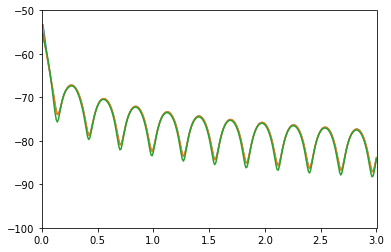

In [5]:
fig, ax = plt.subplots()
ax.plot(raxis / 1e3, dB_img)
ax.plot(raxis / 1e3, dB_mode)
ax.plot(raxis / 1e3, dB_wni)
_=ax.set_xlim(0, 3)
_=ax.set_ylim(-100, -50)